In [1]:
import sys
sys.path.insert(0, '/home/yw440/MXGPY/mxgpy')
sys.path.insert(0, '/home/yw440/MyRGPs/')

import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

import scipy.io
from pylab import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import GPy
import numpy as np
np.random.seed(101)

from mxgpy.rgp.rgp import RGP 
from mxgpy.kernel.rbf import RBF
import mxnet as mx
ctx = mx.gpu()
mx.Context.default_ctx = ctx

from mxgpy.util import positive_transform_reverse_numpy
import helper

 /anaconda/envs/py35/lib/python3.5/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning:OpenSSL.rand is deprecated - you should use os.urandom instead
 /anaconda/envs/py35/lib/python3.5/site-packages/mxnet/context.py:144: DeprecationWarning:Context.default_ctx has been deprecated. Please use Context.current_context() instead. Please use test_utils.set_default_context to set a default context


In [2]:
train_motions = ['01', '02', '03', '04', '05', 
                 '06', '07', '08', '09', '10', 
                 '11', '12', '13', '14', '15', 
                 '16', '17', '18', '19', '20', 
                 '21', '22', '23', '24', '25']
test_motions = ['26', '27', '28', '29', '30']
subject = '118'
y_bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
             'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
             'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
            'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']
# list of control signal in order
u_bones = ['None', 'root', 'lfemur', 'ltibia', 'lfoot', 'root', 'rfemur', 'rtibia', 'rfoot', 
      'root', 'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck',
      'thorax', 'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lwrist',
      'thorax', 'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rwrist' ]

m_jump = GPy.util.datasets.cmu_mocap(subject, train_motions, test_motions, sample_every=5, data_set='cmu_mocap')
y_train = helper.extract_independent_bones(m_jump['Y'], m_jump['lbls']) # list of lists of arrays
y_test = helper.extract_independent_bones(m_jump['Ytest'], m_jump['lblstest'])


y_train_dict = {'None':None}
y_train_mean_list, y_train_std_list = [],[]
for i, item in enumerate(y_train):
    out, mean, std = helper.normalise_data(item)
    y_train_dict[y_bones[i]] = out
    y_train_mean_list.append(mean)
    y_train_std_list.append(std)
       
y_test_dict = {}
y_test_mean_list, y_test_std_list = [], []
for i, item in enumerate(y_test):
    out, mean, std = helper.normalise_data(item)
    y_test_dict[y_bones[i]] = out
    y_test_mean_list.append(mean)
    y_test_std_list.append(std)
    


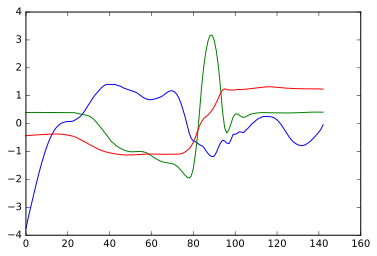

In [26]:
plot(y_train_dict['root'][0][:, :3])

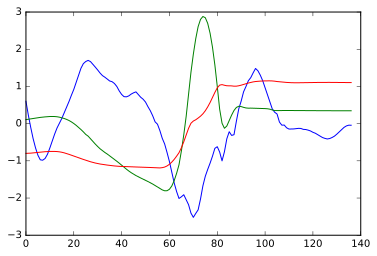

In [27]:
plot(y_train_dict['root'][1][:,:3])

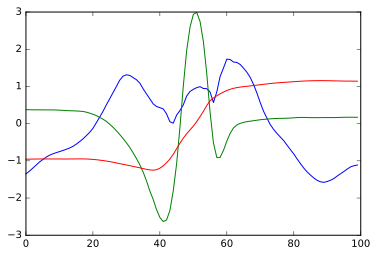

In [28]:
plot(y_train_dict['root'][2][:,:3])

In [ ]:
## ----- TRAINING ---- ##
delta = helper.compute_delta(y_train_dict["root"])

for j, bone in enumerate(y_bones):  
    print(str(j)+'-'+bone)
    
    y_train = y_train_dict[bone]
    if bone is 'root':
        u_train = delta
    else:
        tmp = y_train_dict[u_bones[j]]
        u_train = [[] for _ in range(np.shape(tmp)[0])]
        for i, item in enumerate(tmp):
            u_train[i] = np.hstack([item, delta[i]])
        
    YD = np.shape(y_train[0])[1] # dimension of the data, 62 dimension
    UD = np.shape(u_train[0])[1] # dimension of the control signal

    ## Initialise model
    win_out = 35 # only consider the feature from previous time step
    win_in = 35
    m_control = RGP(wins=[win_out], with_control=True, X_dims=[YD], U_dim=UD, U_win=win_in, num_inducing=60,
                    kernels=[RBF(win_out*YD+win_in*UD, ARD=True)], ctx=ctx, dtype=np.float64)
    
    ## Initialize parameters
    m_control.collect_params()['rbf_variance'].set_data(positive_transform_reverse_numpy(np.array([6.]), np.float64))
    m_control.collect_params()['rbf_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*YD+win_in*UD,))*5.,np.float64))
    m_control.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.0001]),np.float64))

    ## Train model
    
    m_control.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.2)
    m_control.collect_params()['layer_0_noise_var'].grad_req = 'null' # write new noise variance to a single value
    m_control.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.1)
    m_control.collect_params()['layer_0_noise_var'].grad_req = 'write' # write new noise variance to a single value
    m_control.optimize(Y=y_train, U=u_train, max_iters=1500, step_rate=0.05)

    m_control.save_params('./models/all_control/'+str(bone))
    

  0%|          | 0/500 [00:00<?, ?it/s]

0-root


  0%|          | 0/500 [00:00<?, ?it/s]

1-lfemur


  0%|          | 0/500 [00:00<?, ?it/s]

2-ltibia


  0%|          | 0/500 [00:00<?, ?it/s]

3-lfoot


  0%|          | 0/500 [00:00<?, ?it/s]

4-ltoes


  0%|          | 0/500 [00:00<?, ?it/s]

5-rfemur


  0%|          | 0/500 [00:00<?, ?it/s]

13-upperneck


  0%|          | 0/500 [00:00<?, ?it/s]

14-head


  0%|          | 0/500 [00:00<?, ?it/s]

15-lclavicle


  0%|          | 0/500 [00:00<?, ?it/s]

16-lhumerus


  0%|          | 0/500 [00:00<?, ?it/s]

17-lradius


  0%|          | 0/500 [00:00<?, ?it/s]

18-lwrist


  0%|          | 0/500 [00:00<?, ?it/s]

19-lhand


  0%|          | 0/500 [00:00<?, ?it/s]

20-lfingers


  0%|          | 0/500 [00:00<?, ?it/s]

21-lthumb


  0%|          | 0/500 [00:00<?, ?it/s]

22-rclavicle


  0%|          | 0/500 [00:00<?, ?it/s]

23-rhumerus


  0%|          | 0/500 [00:00<?, ?it/s]

24-rradius


  0%|          | 0/500 [00:00<?, ?it/s]

25-rwrist


  0%|          | 0/500 [00:00<?, ?it/s]

26-rhand


  0%|          | 0/500 [00:00<?, ?it/s]

27-rfingers


  0%|          | 0/500 [00:00<?, ?it/s]

28-rthumb


100%|██████████| 1500/1500 [36:29<00:00,  1.46s/it, loss=96.1]   


In [5]:
def test_run(model, seq, win_out, win_in, test_data, control_signal, path, MEAN_PRED=True, with_control=True):
    if with_control:
        YD = np.shape(test_data[0])[-1]; print('Observationa dimension:', YD)
        UD = np.shape(control_signal[0])[-1] ; print('Control signal dimension:', UD)
    
        m = RGP(wins=[win_out], with_control=True, X_dims=[YD], U_dim=UD, U_win=win_in, 
            num_inducing=60, kernels=[RBF(win_out*YD+win_in*UD, ARD=True)], 
            ctx=ctx, dtype=np.float64)
        #'./models/fully_observed/'
        m.load_params(path+model)
    
        y_pd = m.freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:],
                               U=control_signal[seq], mean_predict=False, nSamples=100)
    
        y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
        y_pd_std = y_pd.std(0)
    
    if MEAN_PRED:
        return y_pd_mean
    else:
        return y_pd_mean + y_pd_std*np.random.normal(0,0.5,size=(y_pd_mean.shape[0], y_pd_mean.shape[1]))

In [7]:
## --- Testing --- ##
y_test_list = []
for j, bone in enumerate(y_bones):  
    y_test_list.append(y_test_dict[bone])
    
delta = helper.compute_delta(y_test_dict["root"])

## collect predictions from different dimensions and concatenate into a large matrix
## This is the correct order
bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
        'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
        'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
        'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']

u_bones = ['None', 'root', 'lfemur', 'ltibia', 'lfoot', 'root', 'rfemur', 'rtibia', 'rfoot', 
          'root', 'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck',
          'thorax', 'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lwrist',
          'thorax', 'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rwrist' ]

win_out = 35
win_in = 35
control_signal_dict = {}
num_test_seq = np.shape(y_test_list)[1]
y_pds = [[] for _ in range(num_test_seq)]
for i, model in enumerate(bones):
    print ("="*10 + model + "="*10)
    if i==0:
        u_test = delta
    else:
        tmp = control_signal_dict[u_bones[i]]
        u_test = [[] for _ in range(np.shape(tmp)[0])]
        for j, item in enumerate(tmp):
            u_test[j] = np.hstack([item, delta[j]])
        
    u_test_list = []
    #print(np.shape(u_test[0]))
    #print(np.shape(y_test_list[0][0]))
    #break
    for seq in range(num_test_seq):
        y_pd_temp = test_run(model, seq, win_out, win_in, y_test_list[i], u_test, 
                             path='./models/all_control/', MEAN_PRED=True, with_control=True) # output array
        u_test_list.append(y_pd_temp)
        if i==0:
            y_pds[seq] = y_pd_temp
        else:
            y_pds[seq] = np.hstack((y_pds[seq], y_pd_temp))
    control_signal_dict[model] = u_test_list


==========root==========
Observationa dimension: 6
Control signal dimension: 6
Observationa dimension: 6
Control signal dimension: 6
Observationa dimension: 6
Control signal dimension: 6
Observationa dimension: 6
Control signal dimension: 6
Observationa dimension: 6
Control signal dimension: 6
==========lfemur==========
Observationa dimension: 3
Control signal dimension: 12
Observationa dimension: 3
Control signal dimension: 12
Observationa dimension: 3
Control signal dimension: 12
Observationa dimension: 3
Control signal dimension: 12
Observationa dimension: 3
Control signal dimension: 12
==========ltibia==========
Observationa dimension: 1
Control signal dimension: 9
Observationa dimension: 1
Control signal dimension: 9
Observationa dimension: 1
Control signal dimension: 9
Observationa dimension: 1
Control signal dimension: 9
Observationa dimension: 1
Control signal dimension: 9
==========lfoot==========
Observationa dimension: 2
Control signal dimension: 7
Observationa dimension: 2


Observationa dimension: 1
Control signal dimension: 8
Observationa dimension: 1
Control signal dimension: 8
==========rthumb==========
Observationa dimension: 2
Control signal dimension: 7
Observationa dimension: 2
Control signal dimension: 7
Observationa dimension: 2
Control signal dimension: 7
Observationa dimension: 2
Control signal dimension: 7
Observationa dimension: 2
Control signal dimension: 7


In [8]:
mean_list = helper.reshape(y_test_mean_list)
std_list = helper.reshape(y_test_std_list)

## write motion files
## Recover data from normalised prediction before writing motion files    
pds = [[] for _ in range(num_test_seq)]
for seq, preds in enumerate(y_pds):
    pds[seq] = helper.reverse_normalise_data(preds, mean_list[seq], std_list[seq])
    
### Write .amc motion files
for seq, pd in enumerate(pds):
    filename = './predictions/all_control_seq'+str(seq)
    helper.write_amc(pd, filename)

In [9]:
print(helper.compute_MSE(y_test_list, y_pds))

[0.4698166006633836, 0.5520547210721548, 0.7629308449731771, 0.5477406600994573, 0.9498953231530323]


 /anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning:invalid value encountered in true_divide


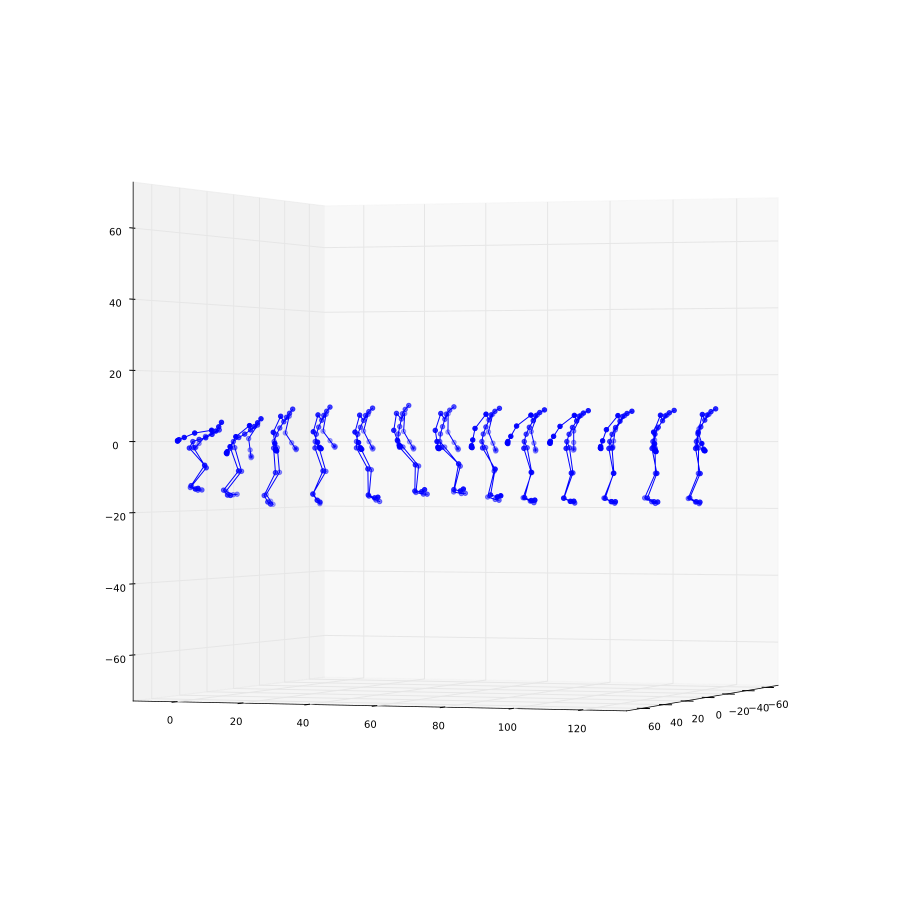

In [11]:
helper.save_trail((pds[1][:,3:]-mean_list[1][3:])/std_list[1][3:], mean_list[1][3:], std_list[1][3:], m_jump['skel'], "all_control")